<a href="https://colab.research.google.com/github/hzchzc123123/CTR/blob/main/PNN%E5%AE%9E%E6%88%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchkeras

In [ ]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from typing import Dict, Text
from ast import literal_eval
from torchkeras import summary,KerasModel

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 数据预处理

In [ ]:
dataset_dir = "/content/drive/MyDrive/CRT/Neural CF/NeuralCF/archive/"
credits = pd.read_csv(dataset_dir + 'credits.csv')
keywords = pd.read_csv(dataset_dir + 'keywords.csv')
movies = pd.read_csv(dataset_dir + 'movies_metadata.csv').\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) # Incorrect data type

movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id').\
    merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [ ]:
def get_text(text, obj='name'):
    text = literal_eval(text)

    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)
df['release_date'] = pd.to_datetime(df['release_date'])

# New columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)
df['label'] = (df['vote_average'] > 6.5).astype(int)
df['year_month'] = df['release_date'].dt.strftime('%Y-%m')
df['year_month'] = df['year_month'].astype('object')

df.drop('vote_average', axis=1, inplace=True)
df.drop('release_date', axis=1, inplace=True)
df.drop('cast', axis=1, inplace=True)
df.drop('original_title', axis=1, inplace=True)
df.drop('overview', axis=1, inplace=True)
df.drop('tagline', axis=1, inplace=True)
df.drop('id', axis=1, inplace=True)
df = df.reset_index(drop=True)

In [ ]:
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

In [ ]:
df.head(3)

,adult,budget,genres,original_language,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,vote_count,keywords,crew,characters,actors,label,year_month
0,False,30000000.0,"Animation, Comedy, Family",en,21.946943,Pixar Animation Studios,United States of America,373554033.0,81.0,English,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",1,1995-10
1,False,65000000.0,"Adventure, Fantasy, Family",en,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,262797249.0,104.0,"English, Français",2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",1,1995-12
2,False,0.0,"Romance, Comedy",en,11.712900,"Warner Bros., Lancaster Gate",United States of America,0.0,101.0,English,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph...",0,1995-12


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45558 entries, 0 to 45557
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 45558 non-null  object 
 1   budget                45558 non-null  float64
 2   genres                45558 non-null  object 
 3   original_language     45558 non-null  object 
 4   popularity            45558 non-null  float64
 5   production_companies  45558 non-null  object 
 6   production_countries  45558 non-null  object 
 7   revenue               45558 non-null  float64
 8   runtime               45558 non-null  float64
 9   spoken_languages      45558 non-null  object 
 10  vote_count            45558 non-null  float64
 11  keywords              45558 non-null  object 
 12  crew                  45558 non-null  object 
 13  characters            45558 non-null  object 
 14  actors                45558 non-null  object 
 15  label              

In [ ]:
label = df['label']
df.drop('label', axis=1, inplace=True)

In [ ]:
continuous_counter = 1
categorical_counter = 1
new_columns = []

# 遍历每一列
for col, dtype in df.dtypes.iteritems():
    if dtype == 'float64':
        new_columns.append(f'I{continuous_counter}')
        continuous_counter += 1
    elif dtype == 'object':
        new_columns.append(f'C{categorical_counter}')
        categorical_counter += 1
    else:  # 如果还有其他数据类型，保留原始名称
        new_columns.append(col)

df.columns = new_columns

In [ ]:
df.head()

,C1,I1,C2,C3,I2,C4,C5,I3,I4,C6,I5,C7,C8,C9,C10,C11
0,False,30000000.0,"Animation, Comedy, Family",en,21.946943,Pixar Animation Studios,United States of America,373554033.0,81.0,English,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",1995-10
1,False,65000000.0,"Adventure, Fantasy, Family",en,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,262797249.0,104.0,"English, Français",2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",1995-12
2,False,0.0,"Romance, Comedy",en,11.712900,"Warner Bros., Lancaster Gate",United States of America,0.0,101.0,English,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph...",1995-12
3,False,16000000.0,"Comedy, Drama, Romance",en,3.859495,Twentieth Century Fox Film Corporation,United States of America,81452156.0,127.0,English,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin...",1995-12
4,False,0.0,Comedy,en,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,76578911.0,106.0,English,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb...",1995-02


In [ ]:
sparse_feas = [col for col in df.columns if col[0] == 'C']
dense_feas = [col for col in df.columns if col[0] == 'I']
dense_feas

['I1', 'I2', 'I3', 'I4', 'I5']

In [ ]:
df[sparse_feas] = df[sparse_feas].fillna('-1')
df[dense_feas] = df[dense_feas].fillna(0)

In [ ]:
# 进行编码  类别特征编码
for feat in sparse_feas:
    le = LabelEncoder()
    df[feat] = le.fit_transform(df[feat])

In [ ]:
# 数值特征归一化
mms = MinMaxScaler()
df[dense_feas] = mms.fit_transform(df[dense_feas])

In [ ]:
df.head()

,C1,I1,C2,C3,I2,C4,C5,I3,I4,C6,I5,C7,C8,C9,C10,C11
0,0,0.078947,1074,18,0.040087,15065,2190,0.133988,0.064490,334,0.384725,12115,19928,38449,38589,1077
1,0,0.171053,940,18,0.031079,19452,2190,0.094261,0.082803,474,0.171439,2744,23119,1007,33503,1079
2,0,0.000000,3280,18,0.021394,21492,2190,0.000000,0.080414,334,0.006536,8310,15798,25435,40361,1079
3,0,0.042105,1381,18,0.007049,19591,2190,0.029216,0.101115,334,0.002416,1847,12049,32984,40575,1079
4,0,0.000000,1222,18,0.015320,16688,2190,0.027468,0.084395,334,0.012291,1394,867,12932,36943,1069


In [ ]:
def sort_columns(column):
    match = re.match(r"([a-z]+)([0-9]+)", column, re.I)
    if match:
        parts = match.groups()
        # 字母部分降序，数字部分升序
        return -ord(parts[0].lower()), int(parts[1])
    return -ord(column.lower()), 0

# 对列名进行排序,由于列名是字符串，不能直接sort
sorted_columns = sorted(df.columns, key=sort_columns)

# 根据排序后的列名重新组织DataFrame
train = df[sorted_columns]
train

,I1,I2,I3,I4,I5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11
0,0.078947,0.040087,0.133988,0.064490,0.384725,0,1074,18,15065,2190,334,12115,19928,38449,38589,1077
1,0.171053,0.031079,0.094261,0.082803,0.171439,0,940,18,19452,2190,474,2744,23119,1007,33503,1079
2,0.000000,0.021394,0.000000,0.080414,0.006536,0,3280,18,21492,2190,334,8310,15798,25435,40361,1079
3,0.042105,0.007049,0.029216,0.101115,0.002416,0,1381,18,19591,2190,334,1847,12049,32984,40575,1079
4,0.000000,0.015320,0.027468,0.084395,0.012291,0,1222,18,16688,2190,334,1394,867,12932,36943,1069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45553,0.000000,0.010382,0.000000,0.082803,0.001847,0,1880,18,21664,399,334,0,19851,34074,30227,1024
45554,0.000000,0.000326,0.000000,0.286624,0.000213,0,1839,80,17329,1660,0,1051,23281,34104,2057,1270
45555,0.000000,0.001649,0.000000,0.071656,0.000426,0,453,18,871,2190,334,0,25664,11004,11495,1171
45556,0.000000,0.000006,0.000000,0.069268,0.000000,0,0,18,22017,1736,0,0,41515,70,15897,160


In [ ]:
train['Label'] = label
train_set, val_set = train_test_split(train, test_size = 0.1, random_state=2020)
train_set.reset_index(drop=True, inplace=True)
val_set.reset_index(drop=True, inplace=True)
train_set['Label'].value_counts()

0    27771
1    13231
Name: Label, dtype: int64

In [ ]:
val_set['Label'].value_counts()

0    3141
1    1415
Name: Label, dtype: int64

In [ ]:
train_set

,I1,I2,I3,I4,I5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,Label
0,0.0,0.020748,0.000000,0.074045,0.009663,0,2840,18,15889,2049,334,25353,23865,18297,21393,1333,0
1,0.0,0.000074,0.000000,0.095541,0.000071,0,1839,63,9526,1693,1273,23884,21137,75,25196,868,0
2,0.0,0.000699,0.000000,0.085191,0.000497,0,1,18,11836,0,334,14356,17124,25586,7153,1028,0
3,0.0,0.000348,0.000000,0.042197,0.000142,0,0,59,12749,1622,1246,0,41662,0,1797,1301,1
4,0.0,0.001743,0.000000,0.067675,0.000497,0,2260,18,4868,2190,631,7091,7806,26420,37741,1321,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40997,0.0,0.011422,0.004676,0.074045,0.005400,0,1528,63,5427,2190,710,2723,14204,8166,25938,1105,0
40998,0.0,0.006038,0.002000,0.115446,0.003197,0,2355,16,17944,396,1260,19166,435,22380,33418,1268,1
40999,0.0,0.001945,0.000000,0.063694,0.000284,0,3288,25,4019,184,943,0,14998,74,12101,1328,0
41000,0.0,0.000072,0.000000,0.080414,0.000071,0,0,18,0,2190,334,0,38487,907,35254,1197,0


In [ ]:
val_set

,I1,I2,I3,I4,I5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,Label
0,0.000000,0.004166,0.0,0.085191,0.000782,0,1968,18,5028,704,334,0,27810,31246,8983,1112,0
1,0.000000,0.000427,0.0,0.069268,0.000142,0,1528,18,12165,2190,334,6425,11882,5984,40907,381,1
2,0.000000,0.000024,0.0,0.039013,0.000284,0,1145,18,3587,2190,334,15431,9558,6062,22066,958,0
3,0.092105,0.033147,0.0,0.099522,0.003979,0,643,88,6743,472,1798,0,39534,6467,18533,1271,0
4,0.016519,0.012914,0.0,0.103503,0.003623,0,2258,66,1247,1736,1295,24192,12860,13955,32785,1332,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551,0.000000,0.003483,0.0,0.107484,0.001776,0,1968,37,16332,1420,1760,23906,22728,14022,2408,1178,1
4552,0.000000,0.001302,0.0,0.070860,0.000142,0,1839,18,0,354,943,18768,25939,34375,25532,1283,0
4553,0.000000,0.001748,0.0,0.080414,0.000071,0,2301,18,12151,1087,334,7849,16099,37559,32475,1087,0
4554,0.000000,0.000489,0.0,0.000000,0.000426,0,2987,18,0,0,0,0,14052,66,14389,1285,0


## 开始PNN

In [ ]:

# 定义一个稀疏特征的embedding映射， 字典{key: value}, key表示每个稀疏特征， value表示数据集data_df对应列的不同取值个数， 作为embedding输入维度
sparse_feas_map = {}
for key in sparse_feas:
    sparse_feas_map[key] = df[key].nunique()
sparse_feas_map

{'C1': 2,
 'C2': 4045,
 'C3': 90,
 'C4': 22401,
 'C5': 2366,
 'C6': 1835,
 'C7': 25853,
 'C8': 42158,
 'C9': 39400,
 'C10': 41786,
 'C11': 1349}

In [ ]:
feature_info = [dense_feas, sparse_feas, sparse_feas_map]  # 这里把特征信息进行封装， 建立模型的时候作为参数传入
feature_info

[['I1', 'I2', 'I3', 'I4', 'I5'],
 ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11'],
 {'C1': 2,
  'C2': 4045,
  'C3': 90,
  'C4': 22401,
  'C5': 2366,
  'C6': 1835,
  'C7': 25853,
  'C8': 42158,
  'C9': 39400,
  'C10': 41786,
  'C11': 1349}]

## 准备数据

In [ ]:
dl_train_dataset = TensorDataset(torch.tensor(train_set.drop(columns='Label').values).float(), torch.tensor(train_set['Label']).float())
dl_val_dataset = TensorDataset(torch.tensor(val_set.drop(columns='Label').values).float(), torch.tensor(val_set['Label']).float())

dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size=16)
dl_vaild = DataLoader(dl_val_dataset, shuffle=True, batch_size=16)

In [ ]:
# 查看一下数据
for b in iter(dl_train):
    print(b[0].shape, b[1])
    break

torch.Size([16, 16]) tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])


## 建立模型

In [ ]:
# 定义一个全连接层的神经网络
class DNN(nn.Module):

    def __init__(self, hidden_units, dropout=0.):
        """
        hidden_units:列表， 每个元素表示每一层的神经单元个数，比如[256, 128, 64]，两层网络， 第一层神经单元128个，第二层64，注意第一个是输入维度
        dropout: 失活率
        """
        super(DNN, self).__init__()

        # 下面创建深层网络的代码 由于Pytorch的nn.Linear需要的输入是(输入特征数量， 输出特征数量)格式， 所以我们传入hidden_units，
        # 必须产生元素对的形式才能定义具体的线性层， 且Pytorch中线性层只有线性层， 不带激活函数。 这个要与tf里面的Dense区分开。
        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        self.dropout = nn.Dropout(p=dropout)

    # 前向传播中， 需要遍历dnn_network， 不要忘了加激活函数
    def forward(self, x):

        for linear in self.dnn_network:
            x = linear(x)
            x = F.relu(x)

        x = self.dropout(x)

        return x

In [ ]:
# 测试一下这个网络
hidden_units = [16, 8, 4, 2, 1]        # 层数和每一层神经单元个数， 由我们自己定义了
dnn = DNN(hidden_units)
summary(dnn, input_shape=(16,))

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Linear-1                                     [-1, 8]                  136
Linear-2                                     [-1, 4]                   36
Linear-3                                     [-1, 2]                   10
Linear-4                                     [-1, 1]                    3
Dropout-5                                    [-1, 1]                    0
Total params: 185
Trainable params: 185
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000061
Forward/backward pass size (MB): 0.000122
Params size (MB): 0.000706
Estimated Total Size (MB): 0.000889
--------------------------------------------------------------------------


'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nLinear-1                                     [-1, 8]                  136\nLinear-2                                     [-1, 4]                   36\nLinear-3                                     [-1, 2]                   10\nLinear-4                                     [-1, 1]                    3\nDropout-5                                    [-1, 1]                    0\n==========================================================================\nTotal params: 185\nTrainable params: 185\nNon-trainable params: 0\n--------------------------------------------------------------------------\nInput size (MB): 0.000061\nForward/backward pass size (MB): 0.000122\nParams size (MB): 0.000706\nEstimated Total Size (MB): 0.000889\n-------------------------------------------

In [ ]:
class ProductLayer(nn.Module):

    def __init__(self, mode, embed_dim, field_num, hidden_units):

        super(ProductLayer, self).__init__()
        self.mode = mode
        # product层， 由于交叉这里分为两部分， 一部分是单独的特征运算， 也就是上面结构的z部分， 一个是两两交叉， p部分， 而p部分还分为了内积交叉和外积交叉
        # 所以， 这里需要自己定义参数张量进行计算
        # z部分的w， 这里的神经单元个数是hidden_units[0], 上面我们说过， 全连接层的第一层神经单元个数是hidden_units[1]， 而0层是输入层的神经
        # 单元个数， 正好是product层的输出层  关于维度， 这个可以看在博客中的分析
        self.w_z = nn.Parameter(torch.rand([field_num, embed_dim, hidden_units[0]]))

        # p部分, 分内积和外积两种操作，关于维度看笔记
        if mode == 'in':#IPNN
            self.w_p = nn.Parameter(torch.rand([field_num, field_num, hidden_units[0]]))
        else:#OPNN
            self.w_p = nn.Parameter(torch.rand([embed_dim, embed_dim, hidden_units[0]]))

        self.l_b = torch.rand([hidden_units[0], ], requires_grad=True)

    def forward(self, z, sparse_embeds):
        # lz部分 具体解释可以看笔记
        l_z = torch.mm(z.reshape(z.shape[0], -1), self.w_z.permute((2, 0, 1)).reshape(self.w_z.shape[2], -1).T)# (None, hidden_units[0])

        # lp 部分
        if self.mode == 'in':  # in模式  内积操作  p就是笔记中两两embedding先内积得到的[field_dim, field_dim]的矩阵
            p = torch.matmul(sparse_embeds, sparse_embeds.permute((0, 2, 1)))  # [None, field_num, field_num]
        else:  # 外积模式  这里的p矩阵是两两embedding先外积得到N*N个[embed_dim, embed_dim]的矩阵， 然后对应位置求和得到最终的1个[embed_dim, embed_dim]的矩阵
            # 所以这里实现的时候， 可以先把sparse_embeds矩阵在field_num方向上先求和， 然后再外积，本质上就是笔记中蓝圈圈出来的位置
            f_sum = torch.unsqueeze(torch.sum(sparse_embeds, dim=1), dim=1)  # [None, 1, embed_dim]
            p = torch.matmul(f_sum.permute((0, 2,1)), f_sum)     # [None, embed_dim, embed_dim]

        #最后求lp,通过将p和w分别展平成向量而得
        l_p = torch.mm(p.reshape(p.shape[0], -1), self.w_p.permute((2, 0, 1)).reshape(self.w_p.shape[2], -1).T)  # [None, hidden_units[0]]

        output = l_p + l_z + self.l_b
        return output

In [ ]:
# 下面我们定义真正的PNN网络
# 这里的逻辑是底层输入（类别型特征) -> embedding层 -> product 层 -> DNN -> 输出
class PNN(nn.Module):

    def __init__(self, feature_info, hidden_units, mode='in', dnn_dropout=0., embed_dim=10, outdim=1):
        """
        DeepCrossing：
            feature_info: 特征信息（数值特征， 类别特征， 类别特征embedding映射)
            hidden_units: 列表， 全连接层的每一层神经单元个数， 这里注意一下， 第一层神经单元个数实际上是hidden_units[1]， 因为hidden_units[0]是输入层，而输入层只输入离散特征
            dropout: Dropout层的失活比例
            embed_dim: embedding的维度m
            outdim: 网络的输出维度
        """
        super(PNN, self).__init__()
        self.dense_feas, self.sparse_feas, self.sparse_feas_map = feature_info
        self.field_num = len(self.sparse_feas)
        self.dense_num = len(self.dense_feas)
        self.mode = mode
        self.embed_dim = embed_dim

         # embedding层， 这里需要一个列表的形式， 因为每个类别特征都需要embedding
        self.embed_layers = nn.ModuleDict({
            'embed_' + str(key): nn.Embedding(num_embeddings=val, embedding_dim=self.embed_dim)
            for key, val in self.sparse_feas_map.items()
        })

        # Product层
        self.product = ProductLayer(mode, embed_dim, self.field_num, hidden_units)

        # dnn 层
        hidden_units[0] += self.dense_num#将数值特征重新加入
        self.dnn_network = DNN(hidden_units, dnn_dropout)
        self.dense_final = nn.Linear(hidden_units[-1], 1)

    def forward(self, x):
        dense_inputs, sparse_inputs = x[:, :5], x[:, 5:]   # 数值型和类别型数据分开
        sparse_inputs = sparse_inputs.long()      # 需要转成长张量， 这个是embedding的输入要求格式
        sparse_embeds = [self.embed_layers['embed_'+key](sparse_inputs[:, i]) for key, i in zip(self.sparse_feas_map.keys(), range(sparse_inputs.shape[1]))]
        # 上面这个sparse_embeds的维度是 [field_num, None, embed_dim] 本质上是大embedding阵
        sparse_embeds = torch.stack(sparse_embeds)
        sparse_embeds = sparse_embeds.permute((1, 0, 2))   # [None, field_num, embed_dim]  注意此时空间不连续， 下面改变形状不能用view，用reshape
        z = sparse_embeds

        # product layer
        sparse_inputs = self.product(z, sparse_embeds)#提供forward部分输入

        # 把上面的连起来， 注意此时要加上数值特征，此处为L1层
        l1 = F.relu(torch.cat([sparse_inputs, dense_inputs], axis=-1))
        # dnn_network
        dnn_x = self.dnn_network(l1)

        outputs = F.sigmoid(self.dense_final(dnn_x))

        return outputs

In [ ]:
hidden_units = [256, 128, 64]
hidden_units_copy = hidden_units.copy()
net = PNN(feature_info, hidden_units, mode='in')
summary(net, input_shape=(train_set.shape[1],))

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Embedding-1                                 [-1, 10]                   20
Embedding-2                                 [-1, 10]               40,450
Embedding-3                                 [-1, 10]                  900
Embedding-4                                 [-1, 10]              224,010
Embedding-5                                 [-1, 10]               23,660
Embedding-6                                 [-1, 10]               18,350
Embedding-7                                 [-1, 10]              258,530
Embedding-8                                 [-1, 10]              421,580
Embedding-9                                 [-1, 10]              394,000
Embedding-10                                [-1, 10]              417,860
Embedding-11                                [-1, 10]               13,490
ProductLayer-12                      

'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nEmbedding-1                                 [-1, 10]                   20\nEmbedding-2                                 [-1, 10]               40,450\nEmbedding-3                                 [-1, 10]                  900\nEmbedding-4                                 [-1, 10]              224,010\nEmbedding-5                                 [-1, 10]               23,660\nEmbedding-6                                 [-1, 10]               18,350\nEmbedding-7                                 [-1, 10]              258,530\nEmbedding-8                                 [-1, 10]              421,580\nEmbedding-9                                 [-1, 10]              394,000\nEmbedding-10                                [-1, 10]              417,860\nEmbedding-11          

In [ ]:
for fea, label in iter(dl_train):
    print(fea.shape, label.shape)
    out = net(fea)
    print(out)
    break

torch.Size([16, 16]) torch.Size([16])
tensor([[0.7442],
        [0.6664],
        [0.7716],
        [0.5599],
        [0.3281],
        [0.6648],
        [0.7529],
        [0.7788],
        [0.5320],
        [0.8685],
        [0.7182],
        [0.6090],
        [0.4822],
        [0.4422],
        [0.4251],
        [0.5867]], grad_fn=<SigmoidBackward0>)


## 模型的训练

In [ ]:
# 模型的相关设置
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)     # 计算AUC， 但要注意如果y只有一个类别的时候， 会报错

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0001, weight_decay=0.01)
metric_func = auc
metric_name = 'auc'

In [ ]:
epochs = 8
log_step_freq = 100
patience = 2
best_val_loss = float('inf')
patience_counter = 0

dfhistory = pd.DataFrame(columns=["epoch", "loss", metric_name, "val_loss", "val_"+metric_name])
print('Start Training...')
nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print('========='*8 + "%s" %nowtime)

for epoch in range(1, epochs+1):
    # 训练阶段
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1

    for step, (features, labels) in enumerate(dl_train, 1):

        # 梯度清零
        optimizer.zero_grad()

        # 正向传播
        predictions = net(features)
        predictions = predictions.squeeze()
        loss = loss_func(predictions, labels)
        try:          # 这里就是如果当前批次里面的y只有一个类别， 跳过去
            metric = metric_func(predictions, labels)
        except ValueError:
            pass

        # 反向传播求梯度
        loss.backward()
        optimizer.step()

        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                  (step, loss_sum/step, metric_sum/step))

    # 验证阶段
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1

    for val_step, (features, labels) in enumerate(dl_vaild, 1):
        with torch.no_grad():
            predictions = net(features)
            predictions = predictions.squeeze()
            val_loss = loss_func(predictions, labels)
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                pass
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()

    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 重置计数器
    else:
        patience_counter += 1  # 增加计数器

    # 检查是否达到早停条件
    if patience_counter >= patience:
        print("Stopping early due to increasing val loss!")
        break

    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
          "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f")
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

print('Finished Training...')

Start Training...
========================================================================2023-11-13 11:38:04
[step = 100] loss: 0.729, auc: 0.513
[step = 200] loss: 0.725, auc: 0.525
[step = 300] loss: 0.708, auc: 0.530
[step = 400] loss: 0.688, auc: 0.538
[step = 500] loss: 0.682, auc: 0.540
[step = 600] loss: 0.676, auc: 0.541
[step = 700] loss: 0.669, auc: 0.544
[step = 800] loss: 0.667, auc: 0.542
[step = 900] loss: 0.665, auc: 0.543
[step = 1000] loss: 0.664, auc: 0.542
[step = 1100] loss: 0.662, auc: 0.543
[step = 1200] loss: 0.658, auc: 0.545
[step = 1300] loss: 0.657, auc: 0.547
[step = 1400] loss: 0.657, auc: 0.546
[step = 1500] loss: 0.656, auc: 0.546
[step = 1600] loss: 0.655, auc: 0.546
[step = 1700] loss: 0.653, auc: 0.547
[step = 1800] loss: 0.651, auc: 0.549
[step = 1900] loss: 0.650, auc: 0.552
[step = 2000] loss: 0.648, auc: 0.553
[step = 2100] loss: 0.648, auc: 0.555
[step = 2200] loss: 0.647, auc: 0.556
[step = 2300] loss: 0.645, auc: 0.558
[step = 2400] loss: 0.644

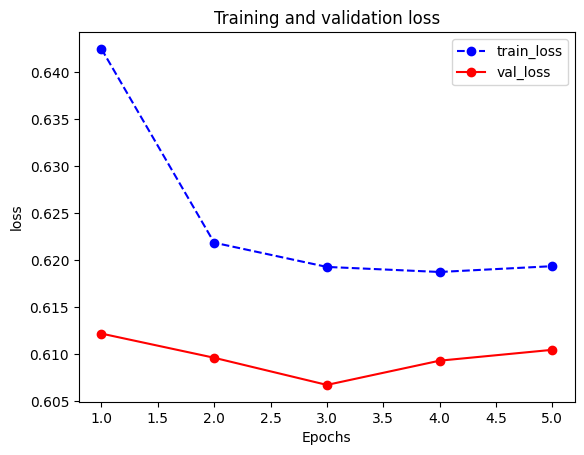

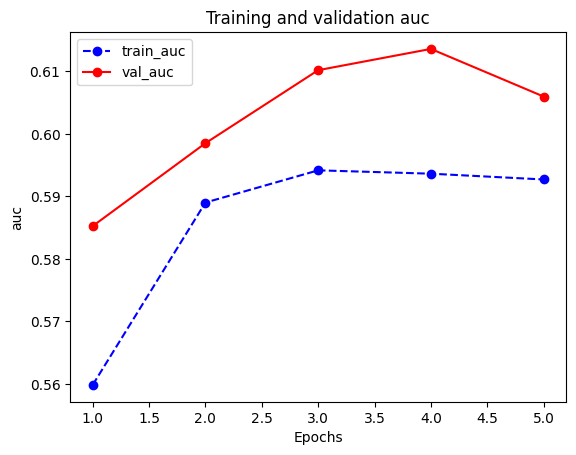

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# 观察损失和准确率的变化
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"auc")

#这tmd结果就一坨狗屎